<a href="https://colab.research.google.com/github/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Activate GPU

1.   Runtime menu
2.   Change runtime type
3.   Hardware accelerator -> GPU

## Get Foolbox

#### Solution

In [1]:
!pip3 install foolbox==3.1.1
# !pip3 install git+https://github.com/bethgelab/foolbox.git

     |████████████████████████████████| 1.7MB 3.0MB/s 
     |████████████████████████████████| 163kB 12.7MB/s 
     |████████████████████████████████| 71kB 4.7MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import foolbox as fb

## Get a model

Get a pertrained PyTorch or TensorFlow model, e.g. `torchvision.models.resnet18` or `tf.keras.applications.ResNet50`.

#### PyTorch

#### Solution

In [3]:
import torch
import torchvision

In [4]:
torch.__version__

'1.6.0+cu101'

In [5]:
torch.cuda.is_available()

True

In [6]:
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [7]:
model = model.eval()

#### TensorFlow

#### Solution

In [ ]:
!pip3 install --upgrade tensorflow

  Using cached https://files.pythonhosted.org/packages/85/d4/c0cd1057b331bc38b65478302114194bd8e1b9c2bbc06e300935c0e93d90/tensorflow-2.1.0-cp36-cp36m-manylinux2010_x86_64.whl
     |████████████████████████████████| 450kB 8.7MB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.1.0'

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
model = tf.keras.applications.ResNet50(weights="imagenet")

In [ ]:
model = tf.keras.applications.ResNet50V2(weights="imagenet")

In [ ]:
model = tf.keras.applications.MobileNetV2(weights="imagenet")

14540800/14536120 [==============================] - 3s 0us/step


## Turn your PyTorch / TensorFlow model into a Foolbox model

Don't forget to specify the correct bounds and preprocessing!

#### PyTorch Solution

In [8]:
# PyTorch ResNet18
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)

#### TensorFlow Solution

In [ ]:
# TensorFlow ResNet50
preprocessing = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])
bounds = (0, 255)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

In [ ]:
# TensorFlow ResNet50V2
preprocessing = dict()
bounds = (-1, 1)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

In [ ]:
# TensorFlow MobileNetV2
preprocessing = dict()
bounds = (-1, 1)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

## Transform bounds

In the following, we want to work with a model that has `(0, 1)` bounds. Use `fmodel.transform_bounds`.

#### Solution

In [9]:
fmodel = fmodel.transform_bounds((0, 1))

In [10]:
assert fmodel.bounds == (0, 1)

## Get some test images

Get a batch of 16 images and the corrresponding labels. You can use `foolbox.utils.samples` to get up to 20 images, but you can also you your own data loader.

#### Solution

In [11]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

## Check the accuracy of your model to make sure you specified the correct preprocessing

#### Solution

In [12]:
fb.utils.accuracy(fmodel, images, labels)

0.9375

In [13]:
type(images), images.shape

(torch.Tensor, torch.Size([16, 3, 224, 224]))

In [14]:
type(labels), labels.shape

(torch.Tensor, torch.Size([16]))

## Run LinfDeepFool

#### Solution

In [15]:
attack = fb.attacks.LinfDeepFoolAttack()

In [16]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

/usr/local/lib/python3.6/dist-packages/eagerpy/tensor/base.py:66: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  return type(self)(self.raw.__add__(unwrap1(other)))


In [17]:
is_adv

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

## Use EagerPy tensors and rerun the attack

#### Solution

In [18]:
import eagerpy as ep

In [19]:
images = ep.astensor(images)
labels = ep.astensor(labels)

In [20]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [21]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

In [22]:
is_adv.float32().mean().item()

1.0

## Using the Misclassification criterion explicitly

#### Solution

In [23]:
criterion = fb.criteria.Misclassification(labels)

In [24]:
raw, clipped, is_adv = attack(fmodel, images, criterion, epsilons=0.03)

In [25]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

## Run the attack using many epsilons

#### Solution

In [26]:
import numpy as np

In [27]:
epsilons = np.linspace(0.0, 0.005, num=20)

In [28]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

In [29]:
is_adv.shape

torch.Size([20, 16])

In [30]:
is_adv.float32().mean(axis=-1)

PyTorchTensor(tensor([0.0625, 0.1875, 0.3125, 0.5625, 0.6875, 0.8125, 0.8750, 0.9375, 0.9375,
                      0.9375, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                      1.0000, 1.0000], device='cuda:0'))

In [31]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)

In [32]:
robust_accuracy

PyTorchTensor(tensor([0.9375, 0.8125, 0.6875, 0.4375, 0.3125, 0.1875, 0.1250, 0.0625, 0.0625,
                      0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                      0.0000, 0.0000], device='cuda:0'))

## Plot the robust accuracy as a function of epsilon

#### Solution

In [33]:
import matplotlib.pyplot as plt

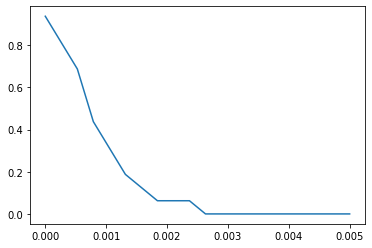

In [34]:
plt.plot(epsilons, robust_accuracy.numpy())

We can see that **the model is not robust** at all. Even extremely small perturbations (Linf norm of 0.003 for pixels between 0 and 1) are sufficient
to change the classification.

## Run a targeted attack

#### Solution

In [35]:
labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99], device='cuda:0'))

In [36]:
target_classes = (labels + 200) % 1000

In [37]:
target_classes

PyTorchTensor(tensor([443, 759, 638, 190, 149,  53, 809, 809, 115, 655, 741, 830, 941, 671,
                      329, 299], device='cuda:0'))

In [38]:
criterion = fb.criteria.TargetedMisclassification(target_classes)

In [39]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100)
# Note: 100 is too little -> results will be bad = perturbations will be relatively large (but 1000 takes much longer)

In [40]:
# epsilons = np.linspace(0.0, 10.0, num=20)
epsilons = None

In [41]:
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

In [42]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

In [47]:
fb.distances.l2(images, advs)

PyTorchTensor(tensor([0.8853, 1.0038, 0.5270, 0.8549, 0.7424, 1.3747, 0.5278, 0.7947, 0.8935,
                      1.0182, 0.8118, 0.4180, 1.8525, 0.3250, 0.6944, 0.7207],
                     device='cuda:0'))

In [48]:
# attack_success_rate = is_adv.float32().mean(axis=-1)

In [49]:
# plt.plot(epsilons, attack_success_rate.numpy())

## Visualizing adversarial examples and perturbations

#### Solution

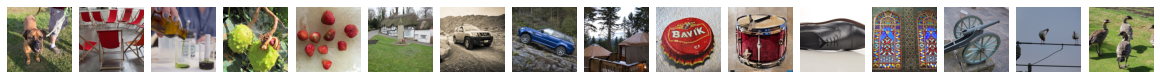

In [50]:
fb.plot.images(images)

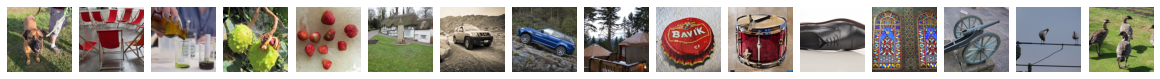

In [51]:
fb.plot.images(advs)

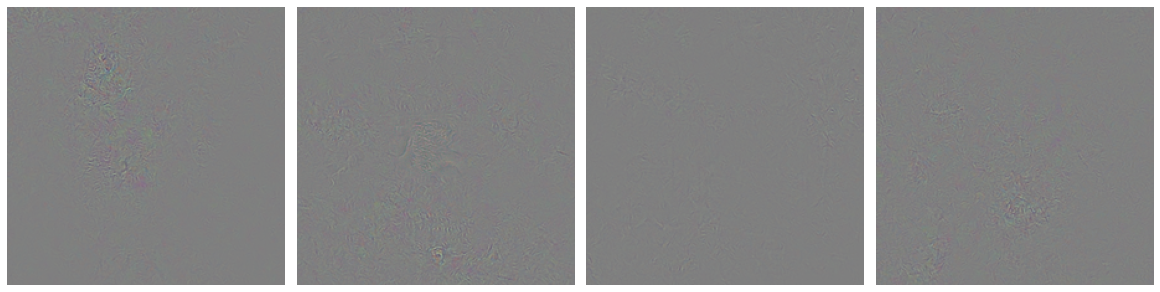

In [53]:
fb.plot.images(advs - images, n=4, bounds=(-0.1, 0.1), scale=4.)

The adversarial examples look like the orignal (clean) images. That shows that **the model is not robust against adversarial attacks**. Tiny perturbations mislead the model and allow the attacker to control which class is recognized.

## Continuing from here ...



*   Repeating an attack (`attack = attack.repeat(3)`)
*   Getting the per-sample worst-case over multiple attacks
    * stack attack results and take max over the attacks before taking the mean over samples
*   Gradient estimators (`fb.gradient_estimators.*`)
*   Transfer attacks using gradient substitution (see examples)

